In [4]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [48]:
import os

PATH = "../blockchainnode/db_nodes"
fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
fdbs.sort()
print(fdbs)

['../blockchainnode/db_nodes/7031.db', '../blockchainnode/db_nodes/7032.db', '../blockchainnode/db_nodes/7033.db', '../blockchainnode/db_nodes/7034.db', '../blockchainnode/db_nodes/7035.db', '../blockchainnode/db_nodes/7036.db', '../blockchainnode/db_nodes/7037.db', '../blockchainnode/db_nodes/7038.db']


[0, 0, 2, 1, 1, 2, 1, 1]
[1, 1, 1, 3, 0, 1, 1, 0]


Text(0, 0.5, 'Count')

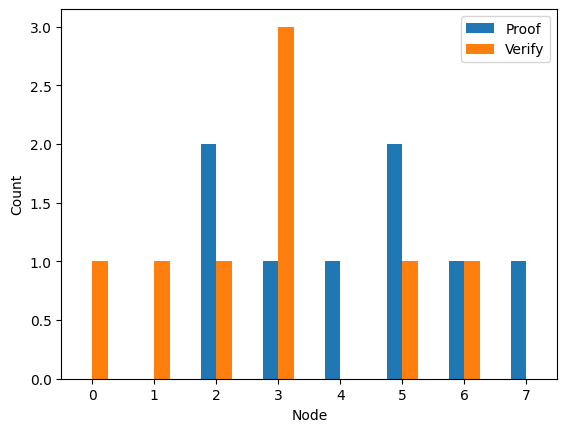

In [57]:
# Count chart for proof and verify
from matplotlib import pyplot as plt

dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif)

ch_list = [proof, verif]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Count")


[nan, nan, 13.4125, 13.373, 29.675, 9.0405, 7.524, 14.742]
[11859.638, 15951.024, 15287.527, 9811.735666666666, nan, 5717.561, 5895.809, nan]
[2430.423, 1275.127, 1970.395, 2608.649, nan, 516.539, 1555.284, nan]


Text(0, 0.5, 'Time[msec]')

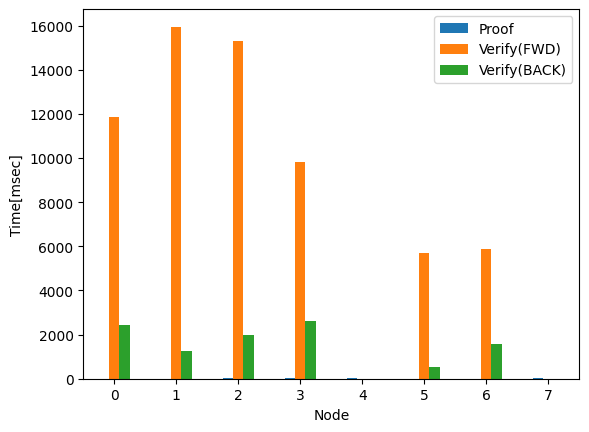

In [61]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
verifrev = []
for i, df in enumerate(dfs):
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    verifrev.append(df['timeverifrev'].mean()/unit)
print(veriffwd)
print(verifrev)

ch_list = [proof, veriffwd, verifrev]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify(FWD)', 'Verify(BACK)']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Time[msec]")

[nan, nan, 1.542196, 1.461116, 1.346724, 1.846538, 1.697696, 0.462744]


Text(0, 0.5, 'Size[MByte]')

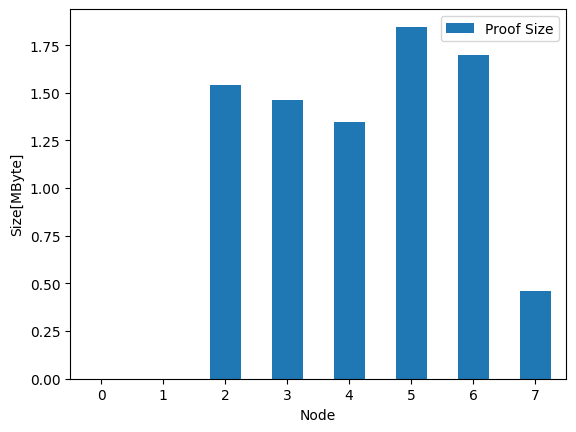

In [64]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['sizegenproof'].mean()/unit)
print(proof)

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof Size']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Size[MByte]")

In [71]:
# List up proof block and show it in the time order 
from matplotlib import pyplot as plt

dfs = load_data_from_db(fdbs, 'prooftbl')
hash = []
for i, df in enumerate(dfs):
    for s in df['proofblock']:        
        hash.append(s)
print(hash)

height = []
for i, df in enumerate(dfs):
    for h in df['proofheight']:        
        height.append(h)
print(height)

ch_list = [hash, height]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Hash', 'Height']

# ax = bdf.plot.bar(rot=0)
# plt.xlabel("Node")
# plt.ylabel("Size[MByte]")

[]
[]
